In [6]:
import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import yaml
import glob, os
import loadcoraldata_utils as coralutils
import json
import importlib
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from osgeo import gdal
from sklearn.manifold import TSNE

from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])

cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])


In [2]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])

cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
mosaic_count = 1

print("Mosaic Count: ", mosaic_count)
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
truthpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
lorespathfile = './test_rasterlores.TIF'

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])

Fiji.export_raster_lores(lorespathfile, downscale=0.5)


Mosaic Count:  1


./utils/loadcoraldata_utils.py:219: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


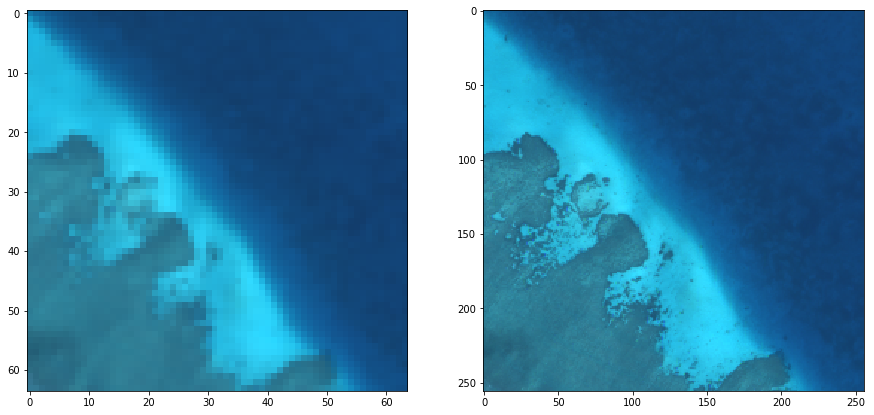

In [5]:
filepath1 = '../Images/Fiji_SR_Patches_64/Lagoonal floor macroalgae on sediment/Lagoonal floor macroalgae on sediment_00000072.tif'
filepath2 = '../Images/Fiji_SR_Patches_256/Lagoonal floor macroalgae on sediment/Lagoonal floor macroalgae on sediment_00000072.tif'
Fiji_test1 = coralutils.CoralData(filepath1, load_type="raster")
Fiji_test2 = coralutils.CoralData(filepath2, load_type="raster")

# Stretch RGB image
patch_R = 255/200*Fiji_test1.image[:,:,4]
patch_G = 255/200*Fiji_test1.image[:,:,2]
patch_B = 255/200*Fiji_test1.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
Fiji_RGB[Fiji_RGB > 255] = 255

fig = plt.figure(1,figsize=(15,15))
ax = plt.subplot(1,2,1)
ax.imshow(Fiji_RGB)

patch_R = 255/200*Fiji_test2.image[:,:,4]
patch_G = 255/200*Fiji_test2.image[:,:,2]
patch_B = 255/200*Fiji_test2.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
Fiji_RGB[Fiji_RGB > 255] = 255
ax = plt.subplot(1,2,2)
ax.imshow(Fiji_RGB)
plt.show()

In [7]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])

cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])

mosaics = [1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]
# mosaics = [1]

output_trainpath = '../Images/Fiji_SR_ValidPatches_64/'
output_trainrefpath = '../Images/Fiji_SR_ValidPatches_256/'
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainpath)
if not os.path.exists(output_trainpath):
    os.makedirs(output_trainrefpath)
output_trainfilename = 'rastervalid.txt'

lorespathfile = './test_rasterlores.TIF'

for mosaic_count in mosaics:
    print("Mosaic Count: ", mosaic_count)
    imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
    truthpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'

    Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
    Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
    Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
    Fiji.export_raster_lores(lorespathfile, downscale=0.25)
    
    Fiji_lores = coralutils.CoralData(lorespathfile, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
    print("Outputing Training...")
    Fiji_lores.export_segmentation_map(output_trainpath, output_trainrefpath, output_trainfilename, image_size = 256, magnification=4,
                                  magimg_path=imgpath, N = 1, lastchannelremove = False, subdir=True, cont=True, consolidated = False)
    print("\n")
    
#     print("Outputing Training...")
#     Fiji.export_segmentation_map(output_trainpath, output_trainrefpath, 
#                                         output_trainfilename, image_size=256, magnification=4, magimg_path=imgpath, 
#                                         N=10, lastchannelremove=False, 
#                                         subdir=True, cont=False, consolidated = True, 
#                                         exporttype=gdal.GDT_Float32, label_cmap=cmap)

    # print("Outputing Validation...")
    # Fiji.export_segmentation_map(output_validpath, output_validrefpath, 
    #                                     output_validfilename, image_size=256, N=5, lastchannelremove=False, 
    #                                     subdir=True, cont=True, consolidated = True,
    #                                     mosaic_mean = mosaic_mean, mosaic_std = mosaic_std)
    
#     for k in Fiji.consolidated_class_dict:
#         consolclass_count[k] = consolclass_count[k] + Fiji.consolclass_count[k]
        
# total_pixels = np.sum([consolclass_count[k] for k in Fiji.consolidated_class_dict])
# consolclass_weights = dict((k, total_pixels/consolclass_count[k]) for k in Fiji.consolidated_class_dict)
# for k in consolclass_weights:
#     if consolclass_weights[k] == float("inf"):
#         consolclass_weights[k] = 0

Mosaic Count:  1


./utils/loadcoraldata_utils.py:221: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


Outputing Training...
17 of 39 total classes found and saved


Mosaic Count:  2
Outputing Training...
17 of 39 total classes found and saved


Mosaic Count:  3
Outputing Training...
17 of 39 total classes found and saved


Mosaic Count:  4
Outputing Training...
26 of 39 total classes found and saved


Mosaic Count:  5
Outputing Training...
27 of 39 total classes found and saved


Mosaic Count:  6
Outputing Training...
27 of 39 total classes found and saved


Mosaic Count:  10
Outputing Training...
18 of 39 total classes found and saved


Mosaic Count:  11
Outputing Training...
18 of 39 total classes found and saved


Mosaic Count:  12
Outputing Training...
18 of 39 total classes found and saved


Mosaic Count:  13
Outputing Training...
18 of 39 total classes found and saved


Mosaic Count:  14
Outputing Training...
23 of 39 total classes found and saved


Mosaic Count:  15
Outputing Training...
27 of 39 total classes found and saved


Mosaic Count:  16
Outputing Training...
28 of 39 to

In [8]:
mosaic_count = 1
lorespathfile = './test_rasterlores.TIF'
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
truthpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
Fiji_lores = coralutils.CoralData(lorespathfile, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")

truthimage = cv2.imread(truthpath)
print(Fiji_lores.geotransform)
print(Fiji_lores.image.shape)
print(Fiji_lores.truthimage[500,500,:])

1253 8.0 2.0
(249118.0, 8.0, 0.0, 8041246.0, 0.0, -8.0)
(1253, 1408, 8)
[27 27 27]
